In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os
import glob

In [2]:
epochs = 10
lr = 1e-3
batch_size = 64
img_dims = (96,96,3)
data = []
labels = []

In [3]:
image_files = [f for f in glob.glob(r'C:\Users\hp\Desktop\ML\Tensorflow\Face_detection\gender_dataset_face' + "/**/*", recursive=True) if not os.path.isdir(f)]
random.shuffle(image_files)

In [4]:
for img in image_files:

    image = cv2.imread(img)
    
    image = cv2.resize(image, (img_dims[0],img_dims[1]))
    image = img_to_array(image)
    data.append(image)

    label = img.split(os.path.sep)[-2] # C:\Files\gender_dataset_face\woman\face_1162.jpg
    if label == "woman":
        label = 1
    else:
        label = 0
        
    labels.append([label]) # [[1], [0], [0], ...]


In [5]:
# pre-processing
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [6]:
# split dataset for training and validation
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2,
                                                  random_state=42)

trainY = to_categorical(trainY, num_classes=2) # [[1, 0], [0, 1], [0, 1], ...]
testY = to_categorical(testY, num_classes=2)

In [7]:
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")

In [8]:
# define model
def build(width, height, depth, classes):
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1

    if K.image_data_format() == "channels_first": #Returns a string, either 'channels_first' or 'channels_last'
        inputShape = (depth, height, width)
        chanDim = 1
    
    # The axis that should be normalized, after a Conv2D layer with data_format="channels_first", 
    # set axis=1 in BatchNormalization.

    model.add(Conv2D(32, (3,3), padding="same", input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(classes))
    model.add(Activation("sigmoid"))

    return model

In [9]:
model = build(width=img_dims[0], height=img_dims[1], depth=img_dims[2],
                            classes=2)



In [10]:
opt = Adam(learning_rate=lr)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [11]:
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=batch_size),
                        validation_data=(testX,testY),
                        steps_per_epoch=len(trainX) // batch_size,
                        epochs=epochs, verbose=1)

C:\Users\hp\AppData\Local\Temp\ipykernel_23660\301311908.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  H = model.fit_generator(aug.flow(trainX, trainY, batch_size=batch_size),


Epoch 1/10
28/28 [==============================] - 24s 777ms/step - loss: 0.7362 - accuracy: 0.7310 - val_loss: 0.9266 - val_accuracy: 0.4892
Epoch 2/10
28/28 [==============================] - 26s 917ms/step - loss: 0.4508 - accuracy: 0.8248 - val_loss: 0.6497 - val_accuracy: 0.5909
Epoch 3/10
28/28 [==============================] - 26s 916ms/step - loss: 0.4065 - accuracy: 0.8377 - val_loss: 1.0370 - val_accuracy: 0.4892
Epoch 4/10
28/28 [==============================] - 21s 769ms/step - loss: 0.3673 - accuracy: 0.8608 - val_loss: 0.7592 - val_accuracy: 0.5260
Epoch 5/10
28/28 [==============================] - 24s 846ms/step - loss: 0.3461 - accuracy: 0.8647 - val_loss: 0.7268 - val_accuracy: 0.5130
Epoch 6/10
28/28 [==============================] - 25s 891ms/step - loss: 0.3370 - accuracy: 0.8703 - val_loss: 0.5924 - val_accuracy: 0.6688
Epoch 7/10
28/28 [==============================] - 24s 854ms/step - loss: 0.2716 - accuracy: 0.8989 - val_loss: 0.9575 - val_accuracy: 0.5260

In [12]:
model.save('gender_detection.model')

INFO:tensorflow:Assets written to: gender_detection.model\assets


INFO:tensorflow:Assets written to: gender_detection.model\assets


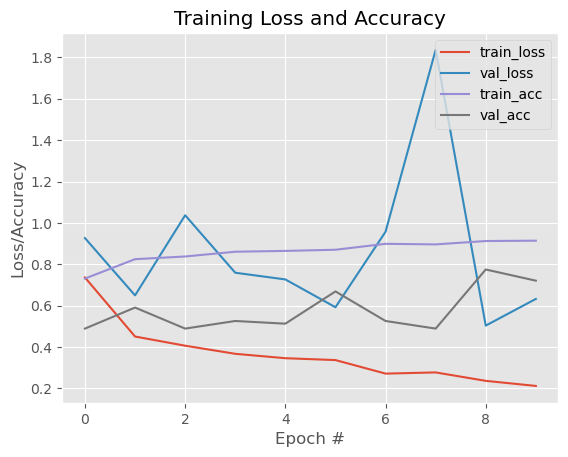

In [13]:
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0,N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,N), H.history["val_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")


In [14]:
# save plot to disk
plt.savefig('plot1.png')

<Figure size 640x480 with 0 Axes>